# 05 - Baseline Strategy
5/15 EMA Crossover with Regime Filter

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from src.strategy import EMARegimeStrategy, trades_to_dataframe
from src.backtest import split_data, run_backtest, calculate_metrics

In [2]:
feature_df = pd.read_csv('../data/nifty_features_5min.csv', parse_dates=['timestamp'])
print(f"Loaded data: {feature_df.shape}")
print(f"Regime distribution: {feature_df['regime'].value_counts().to_dict()}")

Loaded data: (19467, 87)
Regime distribution: {-1: 9545, 1: 6102, 0: 3820}


In [3]:
train_df, test_df = split_data(feature_df, train_ratio=0.7)
print(f"Training: {len(train_df)} rows ({train_df['timestamp'].min()} to {train_df['timestamp'].max()})")
print(f"Testing: {len(test_df)} rows ({test_df['timestamp'].min()} to {test_df['timestamp'].max()})")

Training: 13626 rows (2025-01-16 11:10:00 to 2025-09-30 09:30:00)
Testing: 5841 rows (2025-09-30 09:35:00 to 2026-01-16 12:55:00)


In [4]:
strategy = EMARegimeStrategy(fast_period=5, slow_period=15)
print("Strategy Rules:")
print("  LONG: 5 EMA crosses above 15 EMA AND Regime = +1 (Uptrend)")
print("  SHORT: 5 EMA crosses below 15 EMA AND Regime = -1 (Downtrend)")
print("  EXIT: EMA crossover reverses")
print("  NO TRADE: Regime = 0 (Sideways)")

Strategy Rules:
  LONG: 5 EMA crosses above 15 EMA AND Regime = +1 (Uptrend)
  SHORT: 5 EMA crosses below 15 EMA AND Regime = -1 (Downtrend)
  EXIT: EMA crossover reverses
  NO TRADE: Regime = 0 (Sideways)


In [5]:
print("\n=== TRAINING PERIOD RESULTS ===")
train_df_signals = strategy.generate_signals(train_df)
train_trades = strategy.run(train_df_signals)
train_trades_df = trades_to_dataframe(train_trades)
train_metrics = calculate_metrics(train_trades_df)

print(f"\nTotal Trades: {train_metrics.total_trades}")
print(f"Winning: {train_metrics.winning_trades} | Losing: {train_metrics.losing_trades}")
print(f"Win Rate: {train_metrics.win_rate:.2f}%")
print(f"Total Return: ₹{train_metrics.total_return:.2f} ({train_metrics.total_return_pct:.2f}%)")
print(f"Sharpe Ratio: {train_metrics.sharpe_ratio:.3f}")
print(f"Max Drawdown: ₹{train_metrics.max_drawdown:.2f} ({train_metrics.max_drawdown_pct:.2f}%)")


=== TRAINING PERIOD RESULTS ===

Total Trades: 409
Winning: 131 | Losing: 278
Win Rate: 32.03%
Total Return: ₹2206.47 (2.21%)
Sharpe Ratio: 6.757
Max Drawdown: ₹1542.42 (1.51%)


In [6]:
print("\n=== TEST PERIOD RESULTS (Out-of-Sample) ===")
strategy_test = EMARegimeStrategy(fast_period=5, slow_period=15)
test_df_signals = strategy_test.generate_signals(test_df)
test_trades = strategy_test.run(test_df_signals)
test_trades_df = trades_to_dataframe(test_trades)
test_metrics = calculate_metrics(test_trades_df)

print(f"\nTotal Trades: {test_metrics.total_trades}")
print(f"Winning: {test_metrics.winning_trades} | Losing: {test_metrics.losing_trades}")
print(f"Win Rate: {test_metrics.win_rate:.2f}%")
print(f"Total Return: ₹{test_metrics.total_return:.2f} ({test_metrics.total_return_pct:.2f}%)")
print(f"Sharpe Ratio: {test_metrics.sharpe_ratio:.3f}")
print(f"Sortino Ratio: {test_metrics.sortino_ratio:.3f}")
print(f"Calmar Ratio: {test_metrics.calmar_ratio:.3f}")
print(f"Max Drawdown: ₹{test_metrics.max_drawdown:.2f} ({test_metrics.max_drawdown_pct:.2f}%)")
print(f"Profit Factor: {test_metrics.profit_factor:.3f}")
print(f"Avg Trade Duration: {test_metrics.avg_trade_duration:.1f} minutes")


=== TEST PERIOD RESULTS (Out-of-Sample) ===

Total Trades: 144
Winning: 40 | Losing: 104
Win Rate: 27.78%
Total Return: ₹-903.77 (-0.90%)
Sharpe Ratio: -9.177
Sortino Ratio: -30.878
Calmar Ratio: -68.823
Max Drawdown: ₹1723.55 (1.72%)
Profit Factor: 0.837
Avg Trade Duration: 358.3 minutes


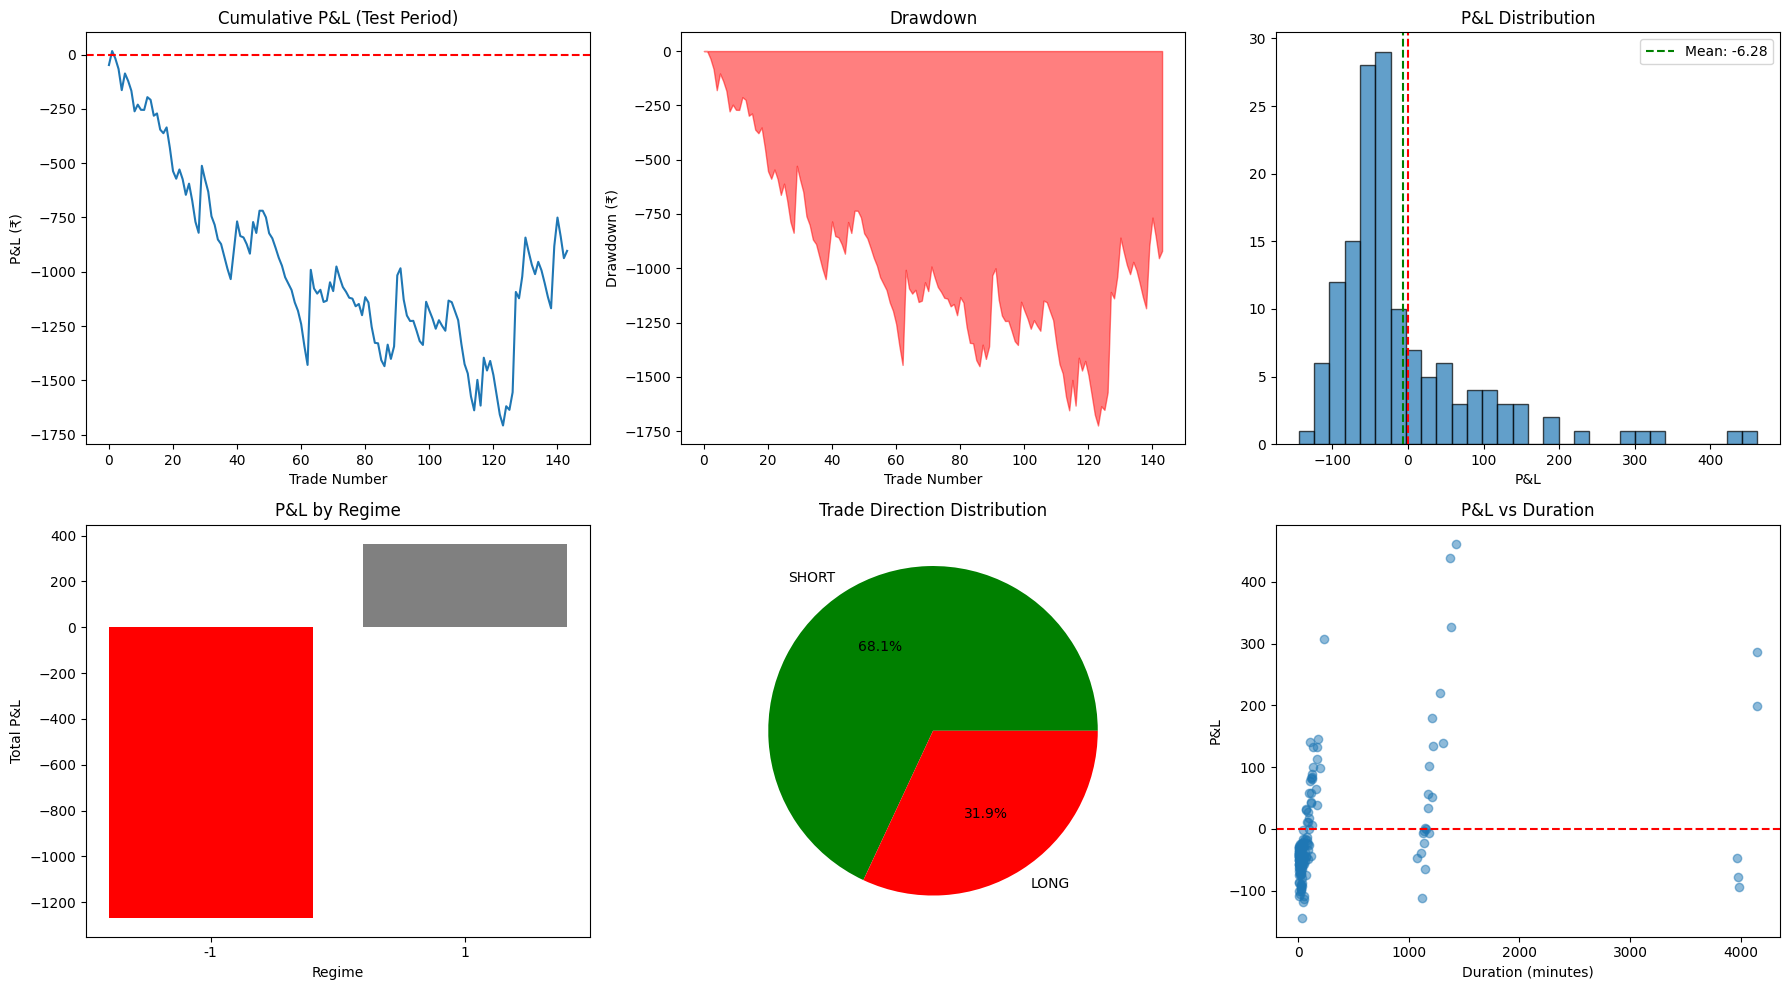

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

cumulative_pnl = test_trades_df['pnl'].cumsum()
axes[0, 0].plot(cumulative_pnl.values)
axes[0, 0].axhline(0, color='r', linestyle='--')
axes[0, 0].set_title('Cumulative P&L (Test Period)')
axes[0, 0].set_xlabel('Trade Number')
axes[0, 0].set_ylabel('P&L (₹)')

equity = 100000 + cumulative_pnl
running_max = equity.expanding().max()
drawdown = (equity - running_max)
axes[0, 1].fill_between(range(len(drawdown)), drawdown.values, 0, alpha=0.5, color='red')
axes[0, 1].set_title('Drawdown')
axes[0, 1].set_xlabel('Trade Number')
axes[0, 1].set_ylabel('Drawdown (₹)')

axes[0, 2].hist(test_trades_df['pnl'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 2].axvline(0, color='r', linestyle='--')
axes[0, 2].axvline(test_trades_df['pnl'].mean(), color='g', linestyle='--', label=f'Mean: {test_trades_df["pnl"].mean():.2f}')
axes[0, 2].set_title('P&L Distribution')
axes[0, 2].set_xlabel('P&L')
axes[0, 2].legend()

regime_pnl = test_trades_df.groupby('regime')['pnl'].sum()
axes[1, 0].bar(regime_pnl.index.astype(str), regime_pnl.values, color=['red', 'gray', 'green'])
axes[1, 0].set_title('P&L by Regime')
axes[1, 0].set_xlabel('Regime')
axes[1, 0].set_ylabel('Total P&L')

position_counts = test_trades_df['position'].value_counts()
axes[1, 1].pie(position_counts.values, labels=position_counts.index, autopct='%1.1f%%', colors=['green', 'red'])
axes[1, 1].set_title('Trade Direction Distribution')

axes[1, 2].scatter(test_trades_df['duration_minutes'], test_trades_df['pnl'], alpha=0.5)
axes[1, 2].axhline(0, color='r', linestyle='--')
axes[1, 2].set_title('P&L vs Duration')
axes[1, 2].set_xlabel('Duration (minutes)')
axes[1, 2].set_ylabel('P&L')

plt.tight_layout()
plt.savefig('../plots/05_baseline_strategy.png', dpi=150)
plt.show()

In [8]:
print("\n=== PERFORMANCE COMPARISON ===")
comparison = pd.DataFrame({
    'Metric': ['Total Return', 'Sharpe Ratio', 'Win Rate', 'Max Drawdown %', 'Total Trades'],
    'Training': [train_metrics.total_return_pct, train_metrics.sharpe_ratio, 
                 train_metrics.win_rate, train_metrics.max_drawdown_pct, train_metrics.total_trades],
    'Testing': [test_metrics.total_return_pct, test_metrics.sharpe_ratio,
               test_metrics.win_rate, test_metrics.max_drawdown_pct, test_metrics.total_trades]
})
print(comparison.to_string(index=False))


=== PERFORMANCE COMPARISON ===
        Metric   Training    Testing
  Total Return   2.206466  -0.903768
  Sharpe Ratio   6.756853  -9.177139
      Win Rate  32.029340  27.777778
Max Drawdown %   1.506661   1.723275
  Total Trades 409.000000 144.000000


In [9]:
test_trades_df.to_csv('../results/baseline_trades.csv', index=False)

results_summary = pd.DataFrame([test_metrics.to_dict()])
results_summary.to_csv('../results/baseline_metrics.csv', index=False)

print("\nSaved:")
print("  - results/baseline_trades.csv")
print("  - results/baseline_metrics.csv")


Saved:
  - results/baseline_trades.csv
  - results/baseline_metrics.csv


In [10]:
print("\n=== SAMPLE TRADES ===")
test_trades_df[['entry_time', 'exit_time', 'position', 'entry_price', 'exit_price', 'pnl', 'regime', 'duration_minutes']].head(10)


=== SAMPLE TRADES ===


,entry_time,exit_time,position,entry_price,exit_price,pnl,regime,duration_minutes
0,2025-09-30 10:50:00,2025-09-30 12:15:00,SHORT,28709.680458,28757.936096,-48.255639,-1,85
1,2025-09-30 12:50:00,2025-09-30 15:25:00,SHORT,28648.644626,28584.301005,64.343621,-1,155
2,2025-10-01 09:15:00,2025-10-01 09:45:00,SHORT,28509.929650,28543.954389,-34.024739,-1,30
3,2025-10-01 09:50:00,2025-10-01 10:05:00,SHORT,28521.407070,28569.803519,-48.396449,-1,15
4,2025-10-02 09:45:00,2025-10-02 10:05:00,SHORT,29123.568384,29221.133126,-97.564742,-1,20
5,2025-10-02 11:35:00,2025-10-02 13:20:00,SHORT,29197.560205,29120.732257,76.827948,-1,105
6,2025-10-02 14:00:00,2025-10-02 15:25:00,SHORT,29041.064080,29075.505345,-34.441265,-1,85
7,2025-10-03 12:40:00,2025-10-03 13:45:00,SHORT,29219.728483,29264.892949,-45.164466,-1,65
8,2025-10-03 15:20:00,2025-10-06 09:45:00,SHORT,29248.182701,29342.879818,-94.697117,-1,3985
9,2025-10-06 11:05:00,2025-10-06 12:10:00,SHORT,29315.627706,29284.742081,30.885624,-1,65
